## --Importing Libraries--

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## --Loading data--

In [2]:
#Importing train dataset
file_path="C:\\Users\\my\\Desktop\\titanic\\train.csv"
train_data = pd.read_csv(file_path)
train_data["train"]=1  # add new column to distangush between train data and test data

#Importing test dataset
test_path="C:\\Users\\my\\Desktop\\titanic\\test.csv"
test_data=pd.read_csv(test_path)
test_data["train"]=0

# Import the actual value for target variable in test dataset
gender_path="C:\\Users\\my\\Desktop\\titanic\\gender_submission.csv"
gender=pd.read_csv(gender_path)

test=pd.merge(test_data,gender,on="PassengerId")

#Merge the train and test dataset
titanic=pd.concat([train_data,test])

## Part One: Statistical Overview

In [3]:
# Find the data structure
titanic.shape

(1309, 13)

.Titanic data has 13 different features from 1309 person

In [4]:
# Verify data feature name and types
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       1309 non-null int64
Ticket         1309 non-null object
train          1309 non-null int64
dtypes: float64(2), int64(6), object(5)
memory usage: 143.2+ KB


In [5]:
# show the first few rows of data
titanic.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,train
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171,1
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1,PC 17599,1
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282,1
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1,113803,1
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0,373450,1


In [6]:
# Changing to appropiate feature type
titanic.Pclass=titanic.Pclass.astype("category")
titanic.Sex=titanic.Sex.astype("category")
titanic.Embarked=titanic.Embarked.astype("category")
titanic.train=titanic.train.astype("object")
titanic.PassengerId=titanic.PassengerId.astype("object")

In [7]:
# Divide the features into categorial and numeric 
cat=titanic.columns[titanic.dtypes=="category"]
num=titanic.columns[titanic.dtypes.isin(["int64","float64"])]

In [8]:
# compute descriptive statistical summary for contionus feature:
titanic.describe(include=np.number)

,Age,Fare,Parch,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000
mean,29.881138,33.295479,0.385027,0.498854,0.377387
std,14.413493,51.758668,0.865560,1.041658,0.484918
min,0.170000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,8.000000,1.000000


In [9]:
# compute descriptive statistical summary for caregorical feature:
titanic.describe(include='category')

,Embarked,Pclass,Sex
count,1307,1309,1309
unique,3,3,2
top,S,3,male
freq,914,709,843


## --Checking for duplicates cases--

In [10]:
titanic.duplicated().sum()

0

The data has zero duplicate cases

## -- Checking for Missing values--

In [11]:
titanic.isnull().sum()/len(titanic)

Age            0.200917
Cabin          0.774637
Embarked       0.001528
Fare           0.000764
Name           0.000000
Parch          0.000000
PassengerId    0.000000
Pclass         0.000000
Sex            0.000000
SibSp          0.000000
Survived       0.000000
Ticket         0.000000
train          0.000000
dtype: float64

## --Feature Engineering--

In [12]:
# Create Title Feature based on their names in the data sets 
titanic['Title']=titanic.Name.str.extract(r'(\w+)\.')
titanic.Title.unique()
titanic.Title = titanic.Title.replace(['Dr','Lady', 'Countess','Capt', 'Col','Don', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
titanic.Title = titanic.Title.replace('Mlle', 'Miss')
titanic.Title = titanic.Title.replace('Ms', 'Miss')
titanic.Title = titanic.Title.replace('Mme', 'Mrs')
titanic.Title = titanic.Title.astype("category")


In [13]:
# Calculate the size of the family 
titanic["FamilySize"]=titanic["SibSp"]+titanic["Parch"]+1

In [14]:
#Based on the fmaily size result we can verify if the person is alone or not
titanic["Alone"]=titanic["FamilySize"].apply(lambda x: 1 if x == 1 else 0)
titanic.Alone=titanic.Alone.astype("category") # change to categorical types

In [15]:
#Based on age feature we can categorize them into age groups from children to elderly
bins=[0,12,18,65,80]
labels=["Children","Teenager","Adults","Elderly"]
titanic["age_group"]=pd.cut(titanic.Age,bins,labels=labels)

## -- Dealing with Missing values--

In [16]:
# For age missing values we can fill it with its median based on Title groups
titanic["Age"].fillna(titanic.groupby(["Title"])["Age"].transform(np.median),inplace=True)

In [17]:
# For Embarked missing values we cam fill it with its most frequent values 
titanic.Embarked.fillna(titanic.Embarked.value_counts().index[0],inplace=True)

In [18]:
# Since we have 70% missing for cabin feature we can drop it from the datasets
titanic.drop(columns=["Cabin"],inplace=True)

## Part Two: Data Visualization

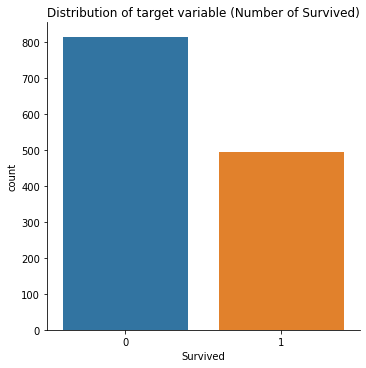

In [19]:
# Visualize The target values  
sns.catplot(x="Survived",data=titanic,kind="count")
plt.title("Distribution of target variable (Number of Survived)")
plt.show()

In [20]:

def feature_plot(df,target,feature):
    df1=pd.pivot_table(df,values=[target],aggfunc=["count","sum","mean"],index=[feature])
    df1.columns=["No","NoSurvived","PerSurvived"]
    print(df1)
    plt.figure(figsize=(15,8))
    return sns.catplot(x=feature,col=target,data=df,kind="count")
    plt.show

In [21]:
cat=titanic.columns[titanic.dtypes=="category"]

           No  NoSurvived  PerSurvived
Embarked                              
C         270         133     0.492593
Q         123          54     0.439024
S         916         307     0.335153
         No  NoSurvived  PerSurvived
Pclass                              
1       323         186     0.575851
2       277         117     0.422383
3       709         191     0.269394
         No  NoSurvived  PerSurvived
Sex                                 
female  466         385      0.82618
male    843         109      0.12930
         No  NoSurvived  PerSurvived
Title                               
Master   61          23     0.377049
Miss    264         209     0.791667
Mr      757          81     0.107001
Mrs     198         172     0.868687
Rare     29           9     0.310345
        No  NoSurvived  PerSurvived
Alone                              
0      519         263     0.506744
1      790         231     0.292405
            No  NoSurvived  PerSurvived
age_group                    

<Figure size 1080x576 with 0 Axes>

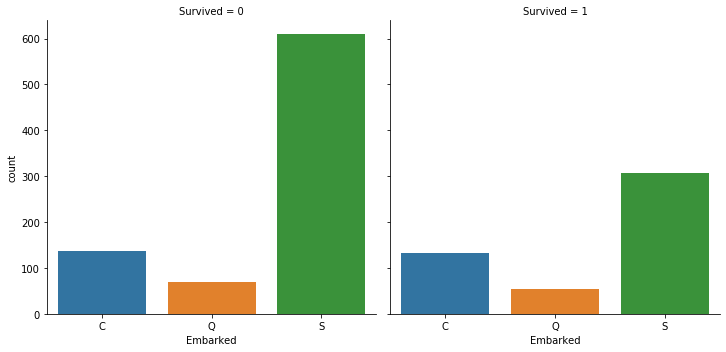

<Figure size 1080x576 with 0 Axes>

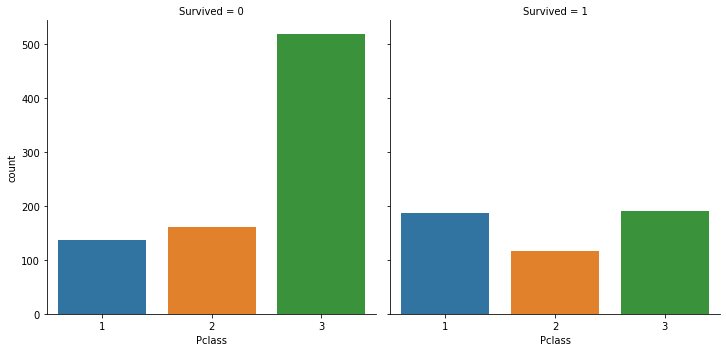

<Figure size 1080x576 with 0 Axes>

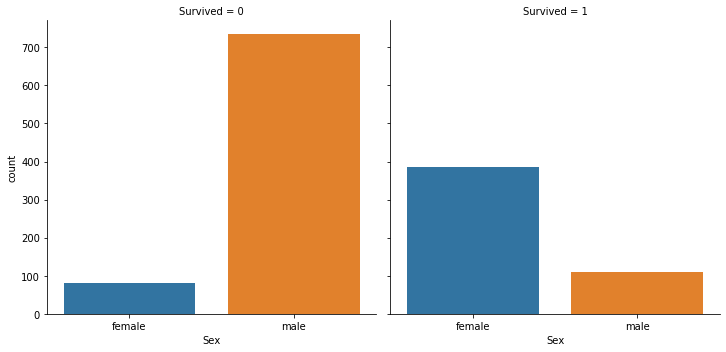

<Figure size 1080x576 with 0 Axes>

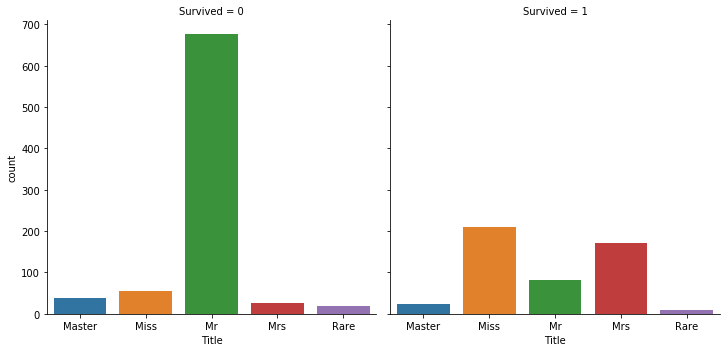

<Figure size 1080x576 with 0 Axes>

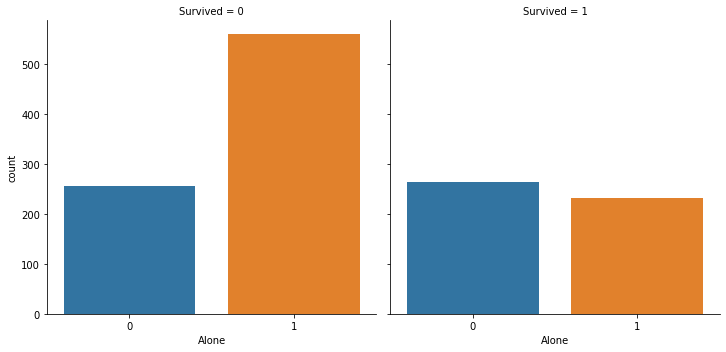

<Figure size 1080x576 with 0 Axes>

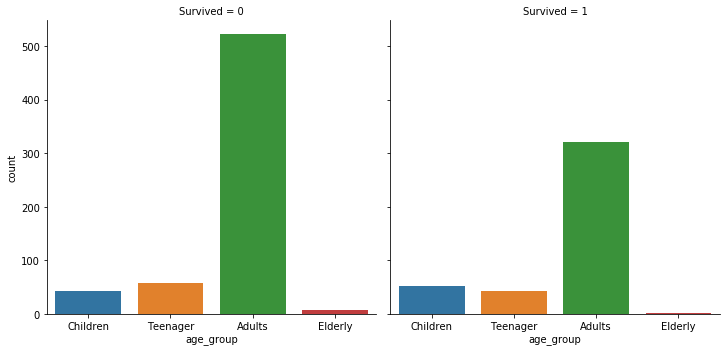

In [22]:
for i in cat:
    feature_plot(titanic,"Survived",i)

In [23]:
def num_feature_plot(df,target,feature):
    df1=pd.pivot_table(df,values=[feature],aggfunc=["mean","std"],index=[target])
    df1.columns=["Mean","Standard Deviation"]
    print(df1)
    plt.figure(figsize=(15,8))
    return sns.catplot(x=target,y=feature,data=df,kind="swarm")
plt.show()

               Mean  Standard Deviation
Survived                               
0         29.906638           12.500696
1         28.607814           14.154701


<Figure size 1080x576 with 0 Axes>

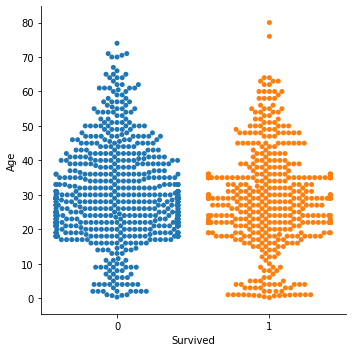

In [24]:
num_feature_plot(titanic,"Survived","Age")
plt.show()

               Mean  Standard Deviation
Survived                               
0         23.879124           34.906946
1         48.811497           68.594401


<Figure size 1080x576 with 0 Axes>

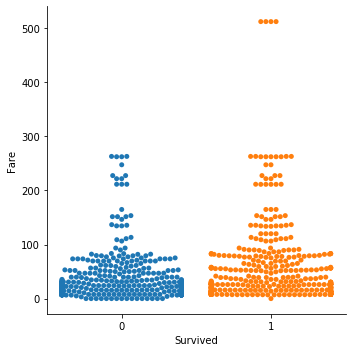

In [25]:
num_feature_plot(titanic,"Survived","Fare")
plt.show()

              Mean  Standard Deviation
Survived                              
0         0.311656            0.843270
1         0.506073            0.888833


<Figure size 1080x576 with 0 Axes>

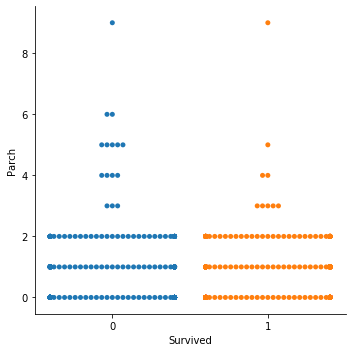

In [26]:
num_feature_plot(titanic,"Survived","Parch")
plt.show()

              Mean  Standard Deviation
Survived                              
0         0.496933            1.164452
1         0.502024            0.799972


<Figure size 1080x576 with 0 Axes>

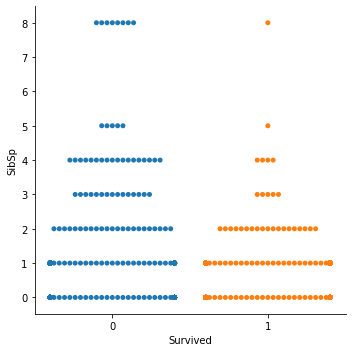

In [27]:
num_feature_plot(titanic,"Survived","SibSp")
plt.show()

## Part Three: Building Staistical model

In [28]:
df=titanic[titanic["train"]==1]
X_train=df.drop(["Survived","Name","Ticket","PassengerId","train"], axis=1)
Y_train=df.Survived
x_train = pd.get_dummies(X_train, columns=["Sex","Embarked","Title","age_group"], drop_first=True)    


In [29]:
x_train.head()

,Age,Fare,Parch,Pclass,SibSp,FamilySize,Alone,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,age_group_Teenager,age_group_Adults,age_group_Elderly
0,22.0,7.2500,0,3,1,2,0,1,0,1,0,1,0,0,0,1,0
1,38.0,71.2833,0,1,1,2,0,0,0,0,0,0,1,0,0,1,0
2,26.0,7.9250,0,3,0,1,1,0,0,1,1,0,0,0,0,1,0
3,35.0,53.1000,0,1,1,2,0,0,0,1,0,0,1,0,0,1,0
4,35.0,8.0500,0,3,0,1,1,1,0,1,0,1,0,0,0,1,0


In [30]:
models=[]
models.append(("LR",LogisticRegression()))
models.append(("LDA",LinearDiscriminantAnalysis()))
models.append(("KNN",KNeighborsClassifier()))
models.append(("CART",DecisionTreeClassifier()))
models.append(("RF",RandomForestClassifier()))
models.append(("NB",GaussianNB()))
models.append(("SVM",SVC()))

In [31]:
seed=7
scoring="accuracy"
result=[]
names=[]

for name,model in models:
    kfold=model_selection.KFold(n_splits=10,random_state=seed)
    cv_result=model_selection.cross_val_score(model,x_train,Y_train,cv=kfold, scoring=scoring)
    result.append(cv_result)
    names.append(name)
    msg="%s: %f (%f)" % (name,cv_result.mean(),cv_result.std())
    print(msg)

LR: 0.821548 (0.036041)
LDA: 0.828315 (0.043088)
KNN: 0.722821 (0.031807)
CART: 0.767753 (0.047987)
RF: 0.802509 (0.043642)
NB: 0.788976 (0.039616)
SVM: 0.752022 (0.039252)


In [32]:
test_data=titanic[titanic["train"]==0]
test_data['Fare'].fillna((test_data['Fare'].mean()), inplace=True)
X_test=test_data.drop(["Survived","Name","Ticket","PassengerId","train"], axis=1)
Y_test=test_data.Survived
x_test= pd.get_dummies(X_test, columns=["Sex","Embarked","Title","age_group"], drop_first=True)    


In [33]:
logistic_model = LogisticRegression()
logistic_model = logistic_model.fit(x_train, Y_train)

In [34]:
predicted = logistic_model.predict(x_test)

In [35]:
print(confusion_matrix(Y_test, predicted))

[[249  17]
 [  7 145]]


In [36]:
print(classification_report(Y_test, predicted))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       266
           1       0.90      0.95      0.92       152

    accuracy                           0.94       418
   macro avg       0.93      0.95      0.94       418
weighted avg       0.94      0.94      0.94       418



In [37]:
print(accuracy_score(Y_test,predicted))

0.9425837320574163


In [48]:
gender["Survived"]=predicted

In [49]:
gender.to_csv("C:\\Users\\my\\Desktop\\titanic\\gender.csv",index=False)